**LOAD DATASET**

In [1]:
import pandas as pd
train_df = pd.read_csv("data/train_res.csv")
test_df = pd.read_csv("data/test.csv")

In [2]:
train_df

,user_id,username,rating,original_text,gmap_id,business_name,translated_text,sentiment_label,sentiment_score,final_with_stopword,final_no_stopword,ori_wc,final_wc,final_no_stopword_wc,label
0,1.018822e+20,WandaRose Edwards,5.0,hair. cuts are great perms are yo so bo to Fa...,0x87f13159c1c981ff:0x152ae1421df3f5d,Fantastic Sams Cut & Color,hair. cuts are great perms are yo so bo to Fa...,POSITIVE,0.998672,hair cut be great perm be yo so bo to fantasti...,hair cut great perm yo bo fantastic sam get ha...,15,15,11,1
1,1.027946e+20,Nancy Nguyen,1.0,This place is the diaster. They never picked u...,0x80c8db13615006c1:0x24135dd0da952b0a,ProCare Medical Center-Nellis,This place is the diaster. They never picked u...,NEGATIVE,0.999504,this place be the diaster they never pick up t...,place diaster never pick phone make appointmen...,162,167,95,0
2,1.171415e+20,Nikki Lenning,5.0,Me and my husband had a great experience! It w...,0x888919a0ee645351:0xbfc5c402383f3ce3,Birmingham Massage Couple,Me and my husband had a great experience! It w...,POSITIVE,0.998939,me and my husband have a great experience it b...,husband great experience first massage really ...,48,51,21,1
3,1.050229e+20,jessica little,5.0,Always best prices,0x885567ed80e10897:0x4da1371f39ae3bf6,Dollar General,Always best prices,POSITIVE,0.998699,always best price,always best price,3,3,3,1
4,1.027384e+20,Megan Paulus-Bonney,2.0,The price is great but expect the type of serv...,0x89c80f244d0cf843:0x98f9905826c22d1b,Beltway Animal Hospital,The price is great but expect the type of serv...,NEGATIVE,0.998978,the price be great but expect the type of serv...,price great expect type service come price tag,16,16,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628387,1.122890e+20,Sara Kirner,5.0,They provide excellent care and very reasonabl...,0x89b7c55a2fad5a29:0xc4f748521d68a5dc,Marymont Animal Hospital Inc,They provide excellent care and very reasonabl...,POSITIVE,0.998932,they provide excellent care and very reasonabl...,provide excellent care reasonable pricing high...,11,11,7,1
628388,1.071383e+20,Zheng Yong,1.0,Too Slow ，It took half an hour to register,0x8636d3c92c60c85d:0xdaf20a9449685c84,Taylor Dental,Too Slow ，It took half an hour to register,NEGATIVE,0.999498,too slow ，it take half an hour to register,slow ，it take half hour register,9,9,6,0
628389,1.168988e+20,Bonnie Smith,1.0,"Wow , i have been in pain for 2 weeks before s...",0x89fb3101e4264c27:0x5dd2f5fa2da3338a,Capeside Oral and Facial Surgery,"Wow , i have been in pain for 2 weeks before s...",POSITIVE,0.998882,wow i have be in pain for 2 week before see dr...,wow pain 2 week see dr latimer come introduce ...,105,99,43,1
628390,1.122568e+20,Julie Brock,5.0,"The Best facials, service and staff! I've trie...",0x89e49fd06a96f981:0x30efd957d3a07915,The Face Place & Spa,"The Best facials, service and staff! I've trie...",POSITIVE,0.998930,the best facial service and staff i have try t...,best facial service staff try newbury st nantu...,46,46,27,1


In [3]:
train_df['label'].value_counts()

label
1    314196
0    314196
Name: count, dtype: int64

In [4]:
test_df

,user_id,username,rating,original_text,gmap_id,business_name,translated_text,sentiment_label,sentiment_score,final_with_stopword,final_no_stopword,ori_wc,final_wc,final_no_stopword_wc,label
0,1.088392e+20,Shayla “The Savage” Herrón,1.0,I was given medicine with aluminum in it while...,0x89b7bcc03286d277:0x7b5a33131bd45735,Patient First - Clinton,I was given medicine with aluminum in it while...,NEGATIVE,0.999505,i be give medicine with aluminum in it while s...,give medicine aluminum still room allergic alu...,116,116,48,0
1,1.020402e+20,___Luckygirl___ 96,5.0,Dr.Ashley is amazing as a person and as a prof...,0x87f63b8caf4a031d:0x5ff6b5d4cc97a3f,Finish Line Wellness,Dr.Ashley is amazing as a person and as a prof...,POSITIVE,0.998914,dr.ashley be amazing a a person and a a profes...,dr.ashley amazing person professionalist make ...,24,24,12,1
2,1.098990e+20,Karetha Strand,1.0,I am gonna go ahead and say this was the worst...,0x89e388889a95d869:0xbff8b346c9e193da,CareWell Urgent Care,I am gonna go ahead and say this was the worst...,NEGATIVE,0.999505,i be go to go ahead and say this be the bad ex...,go go ahead say bad experience ever urgent car...,133,135,67,0
3,1.031164e+20,Jerry Wanty,5.0,Always clean & organized. The few times ive go...,0x8803af1145fd1471:0xb50961d5e3f8bf03,Anytime Fitness,Always clean & organized. The few times ive go...,POSITIVE,0.998919,always clean organize the few time i have go d...,always clean organize time go staffed hour sta...,38,40,19,1
4,1.090251e+20,Breeze Carvajal,3.0,The facial was excellent!!! The mani and pedi ...,0x89c9da598ce74451:0x549f0f3272a06267,Verbena Salon & Spa,The facial was excellent!!! The mani and pedi ...,NEGATIVE,0.999505,the facial be excellent the mani and pedi be t...,facial excellent mani pedi absolute worse ever...,62,64,32,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244593,1.070690e+20,Life of Danno,5.0,I couldn't have asked for better service! Ever...,0x875289b93c87454b:0xd023c096df5f8bf8,The LASIK Vision Institute,I couldn't have asked for better service! Ever...,POSITIVE,0.998932,i could not have ask for good service everyone...,could not ask good service everyone super nice...,47,48,24,1
244594,1.001145e+20,Paul Drees,4.0,"Staff are nice, the layout is kinda wonky but ...",0x87f62a671807c1dd:0x54390419505bb8e2,CVS Pharmacy,"Staff are nice, the layout is kinda wonky but ...",POSITIVE,0.998783,staff be nice the layout be kind of wonky but ...,staff nice layout kind wonky usually find look,17,19,8,1
244595,1.165976e+20,Tesalina Meador,5.0,"I love going to Dr. Avery, he has been my eye ...",0x8865ef49f1dc22bb:0xc385780a7310438e,Avery Eyecare,"I love going to Dr. Avery, he has been my eye ...",POSITIVE,0.998905,i love go to dr. avery he have be my eye docto...,love go dr. avery eye doctor since 7th grade 3...,51,52,24,1
244596,1.183965e+20,Alycia Smith,1.0,"Dr. Petrovich is nice and thorough, and I got ...",0x87528bbc560792a1:0xdd1f08e5b1286aab,UNIVERSITY OF UTAH Health Sugar House Health C...,"Dr. Petrovich is nice and thorough, and I got ...",NEGATIVE,0.999507,dr. petrovich be nice and thorough and i get i...,dr. petrovich nice thorough get initial appoin...,191,192,86,0


In [5]:
test_df['label'].value_counts()

label
1    146411
0     98187
Name: count, dtype: int64

**EXTRACT FEATURES AND LABELS**

In [ ]:
from scipy.stats import uniform
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

X_train_texts = train_df['final_with_stopword'].astype(str).tolist()
y_train = train_df['label'].values
X_test_texts = test_df['final_with_stopword'].astype(str).tolist()
y_test = test_df['label'].values

#load saved tf-idf vectorizer
import pickle
with open("tfidf_vectorizer.pkl", "rb") as f:
    tfidf = pickle.load(f)

#transform text
X_train_tfidf = tfidf.transform(X_train_texts)
X_test_tfidf = tfidf.transform(X_test_texts)

#define parameter grid

param_distributions = {
    'C': uniform(0.01, 10),
    'penalty': ['l2'],
    'solver': ['liblinear'],
    'max_iter': [1000]
}

#randomsearchcv
random_search = RandomizedSearchCV(
    estimator=LogisticRegression(),
    param_distributions=param_distributions,
    n_iter=20,
    scoring='f1',
    cv=5,
    verbose=2,
    n_jobs=2,
    random_state=42
)

random_search.fit(X_train_tfidf, y_train)

**DEFINE PARAMETER GRID**

In [9]:
from sklearn.linear_model import LogisticRegression
LogisticRegression().get_params().keys()


dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

penalty & solver that supports it
l2 = liblinear, lbfgs, saga
l2 = liblinear, saga
elasticnet = saga

In [ ]:
from scipy.stats import uniform
param_distributions = {
    'C': uniform(0.01, 10),
    'penalty': ['l2'],
    'solver': ['liblinear'],
    'max_iter': [1000]
}

**INITIALIZE RandomizedSearchCV**

In [11]:
import os

# Total number of logical CPU cores (including hyperthreading)
print("Logical CPU cores:", os.cpu_count())


Logical CPU cores: 20


In [12]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=LogisticRegression(),
    param_distributions=param_distributions,
    n_iter=20,
    scoring='f1',
    cv=5,
    verbose=2,
    n_jobs=2,
    random_state=42
)

**FIT THE MODEL**

In [13]:

random_search.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20, n_jobs=2,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000018101ECE810>,
                                        'max_iter': [1000], 'penalty': ['l2'],
                                        'solver': ['liblinear']},
                   random_state=42, scoring='f1', verbose=2)

**SAVE BEST MODEL**

In [14]:
import pickle
with open("model_LR_hptune.pkl", "wb") as f:
    pickle.dump(random_search.best_estimator_, f)

**PREDICT ON TEST SET**

In [15]:
# Predict on test set
y_pred = random_search.best_estimator_.predict(X_test_tfidf)
y_proba = random_search.best_estimator_.predict_proba(X_test_tfidf)

In [28]:
import pickle
with open("model_LR_hptune.pkl", "rb") as f:
    loaded_model = pickle.load(f)
    # Predict class labels
y_pred = loaded_model.predict(X_test_tfidf)
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, digits=4))


              precision    recall  f1-score   support

           0     0.9238    0.9571    0.9401     98187
           1     0.9705    0.9470    0.9586    146411

    accuracy                         0.9511    244598
   macro avg     0.9471    0.9520    0.9494    244598
weighted avg     0.9517    0.9511    0.9512    244598



**EVALUATE THE MODEL**

In [ ]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

# Evaluation function
def evaluate_model_sklearn(y_true, y_pred, y_proba, label="Set"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"--- {label} Evaluation ---")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{label} Confusion Matrix")
    plt.tight_layout()
    plt.show()




**BEST PARAMETER**

In [22]:
# Evaluate
print("Best Hyperparameters:", random_search.best_params_)


Best Hyperparameters: {'C': np.float64(3.7554011884736247), 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}


--- Train Set Evaluation ---
Accuracy : 0.9560
Precision: 0.9602
Recall   : 0.9514
F1 Score : 0.9558
Classification Report:
              precision    recall  f1-score   support

           0     0.9518    0.9605    0.9562    314196
           1     0.9602    0.9514    0.9558    314196

    accuracy                         0.9560    628392
   macro avg     0.9560    0.9560    0.9560    628392
weighted avg     0.9560    0.9560    0.9560    628392



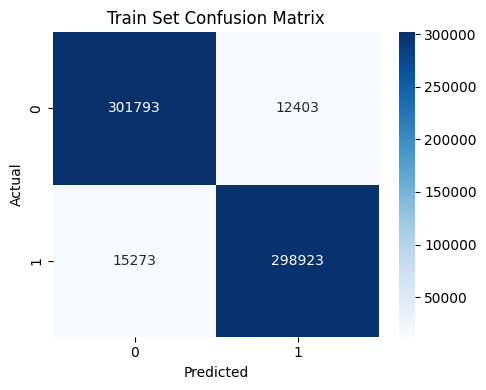

--- Test Set Evaluation ---
Accuracy : 0.9511
Precision: 0.9705
Recall   : 0.9470
F1 Score : 0.9586
Classification Report:
              precision    recall  f1-score   support

           0     0.9238    0.9571    0.9401     98187
           1     0.9705    0.9470    0.9586    146411

    accuracy                         0.9511    244598
   macro avg     0.9471    0.9520    0.9494    244598
weighted avg     0.9517    0.9511    0.9512    244598



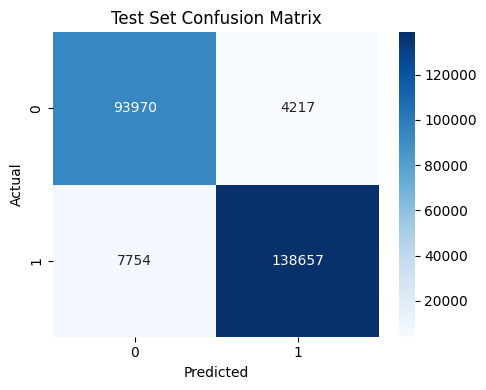

In [23]:
#train set evaluation
y_train_pred = random_search.best_estimator_.predict(X_train_tfidf)
y_train_proba = random_search.best_estimator_.predict_proba(X_train_tfidf)
# Evaluation
evaluate_model_sklearn(y_train, y_train_pred, y_train_proba, label="Train Set")

# same for test
y_test_pred = random_search.best_estimator_.predict(X_test_tfidf)
y_test_proba = random_search.best_estimator_.predict_proba(X_test_tfidf)
evaluate_model_sklearn(y_test, y_test_pred, y_test_proba, label="Test Set")

In [26]:
from sklearn.metrics import log_loss

# Step 1: Predict class probabilities on test set (using TF-IDF input)
# This returns shape (n_samples, 2): [:, 0] = class 0, [:, 1] = class 1
y_test_proba = random_search.best_estimator_.predict_proba(X_train_tfidf)

# Step 2: Use only the probabilities for the positive class (class 1)
y_test_prob_class1 = y_test_proba[:, 1]

# Step 3: Compute binary log loss
logloss = log_loss(y_train, y_test_prob_class1)

# Step 4: Print the result
print(f"Log Loss (Binary, class 1): {logloss:.4f}")


Log Loss (Binary, class 1): 0.1141


In [24]:
from sklearn.metrics import log_loss

# Step 1: Predict class probabilities on test set (using TF-IDF input)
# This returns shape (n_samples, 2): [:, 0] = class 0, [:, 1] = class 1
y_test_proba = random_search.best_estimator_.predict_proba(X_test_tfidf)

# Step 2: Use only the probabilities for the positive class (class 1)
y_test_prob_class1 = y_test_proba[:, 1]

# Step 3: Compute binary log loss
logloss = log_loss(y_test, y_test_prob_class1)

# Step 4: Print the result
print(f"Log Loss (Binary, class 1): {logloss:.4f}")


Log Loss (Binary, class 1): 0.1241


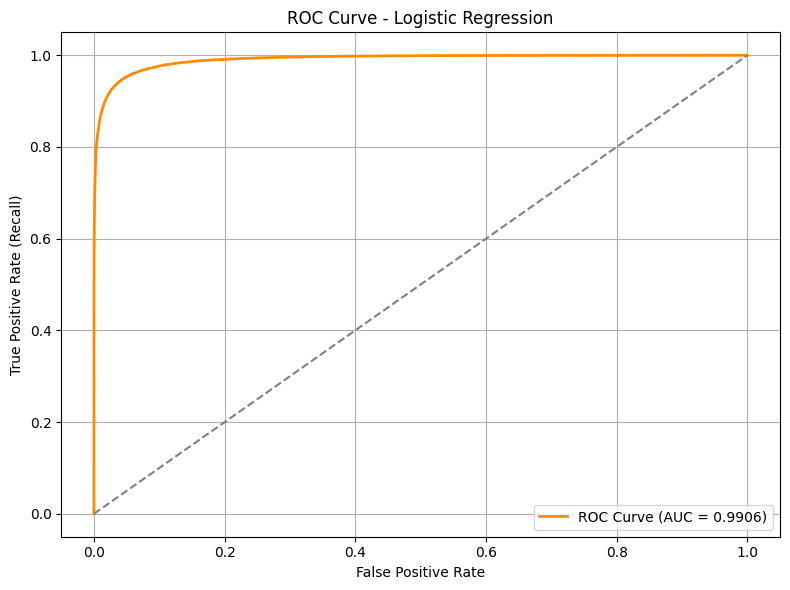

In [27]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Step 1: Get predicted probabilities for the positive class (class 1)
y_test_proba = random_search.best_estimator_.predict_proba(X_test_tfidf)[:, 1]

# Step 2: Compute ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

# Step 3: Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
